# micrograd
Andrej Karpathy's lecture designing a miniature automatic differnetiator



In [159]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='TB'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


In [147]:
class Value():
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data # This is the value 
        self.grad = 0.0 # This is initialized at zero and will be updated as the backward pass computes the gradient, this can be accumulated
        self._backward = lambda: None # Initialized at None because we don't yet know where it is in the graph
        self._prev = set(_children) # Keeps track of all previous nodes that this node is connected to with respect to the loss function
        self._op = _op # This keeps track of what operator was used to generate this value if any
        self.label = label # This keeps track of the variable used to store this value

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # This line is to handle the case if you want to add an int or float to a Value object
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __pow__(self, other):
        assert isinstance(other, (int,float))
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += other*self.data**(other-1) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    # Handle the case when you add or multiply an int or float before a Value object. i.e.: 1+a or 1*a
    #########################
    def __radd__(self, other):
        return self + other

    def __rmul__(self, other):
        return self * other
    #########################    
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad

        out._backward = _backward
        return out

    def __repr__(self):
        return f"Value({self.data})"

In [148]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

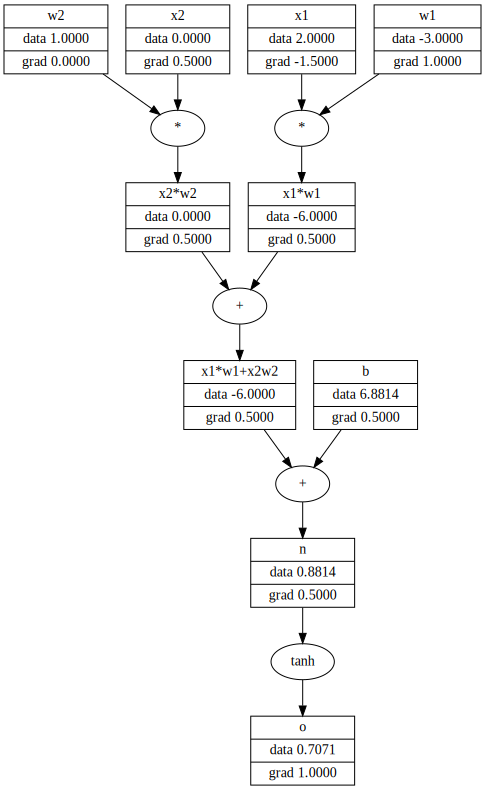

In [149]:
o.backward()
draw_dot(o)

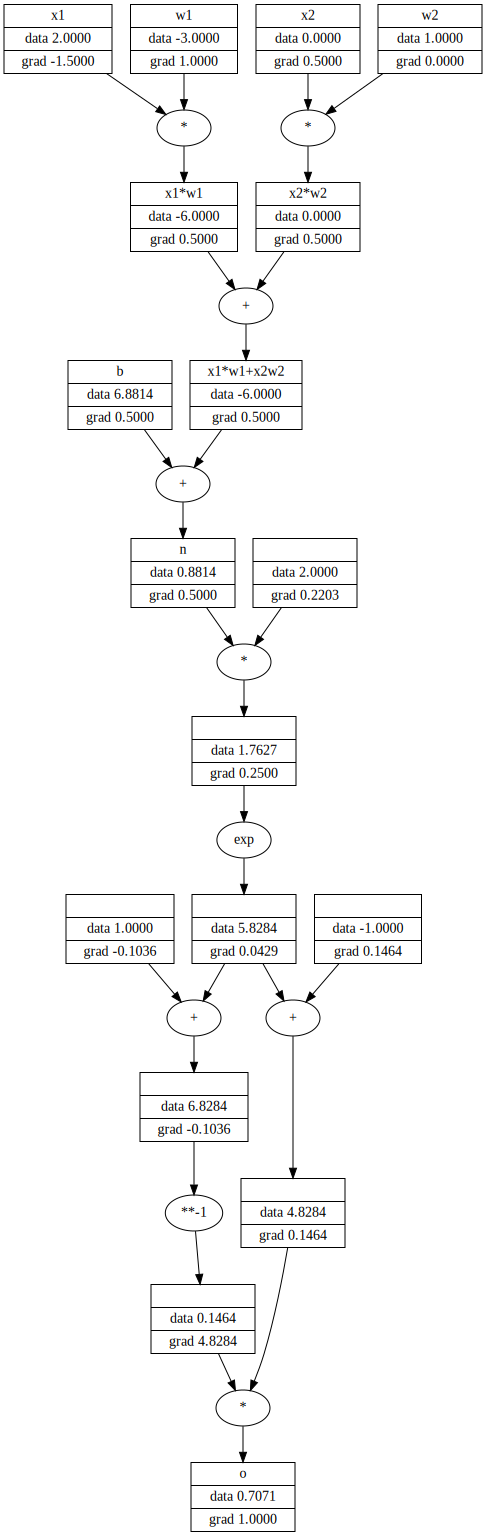

In [151]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2w2'
n = x1w1x2w2 + b; n.label='n'
#-----------------
e = (2*n).exp()
o = (e-1) / (e+1)
#-----------------
o.label='o'
o.backward()
draw_dot(o)

In [158]:
import torch

x1 = torch.Tensor([2.0]).double()                        ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                        ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                       ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                        ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()          ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())
o.backward()
print("-----")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
-----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [235]:
class Neuron():
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b 
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
    
class Layer():
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP():
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [257]:
net = MLP(3, [4,4,1])

In [288]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys= [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [net(x) for x in xs]
ypred

[Value(0.6298212061930774),
 Value(-0.8975804231618386),
 Value(-0.5710088958597754),
 Value(0.6226513744038188)]

In [289]:
# Mean squared error loss
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(0.47394746177483216)

In [290]:
for p in net.parameters():
    p.grad = 0.0
loss.backward()

In [269]:
f"grad = {net.layers[0].neurons[0].w[0].grad} | data = {net.layers[0].neurons[0].w[0].data}"

'grad = -2.266334409656069 | data = -0.493955928116619'

In [287]:
# gradient descent!

LR = 0.01 # Learning rate
for p in net.parameters():
    p.data += -LR * p.grad


In [271]:
f"grad = {net.layers[0].neurons[0].w[0].grad} | data = {net.layers[0].neurons[0].w[0].data}"

'grad = -2.266334409656069 | data = -0.4712925840200583'